### ♦ Augmenting densenet implemention of CIFAR-10 object classification using imgaug library

The following code is written & run on google colab notebook.
* It has an improved accuracy of 80.68% over previous script giving ~78%, as a result of additional training data generated using image augmentation techniques.
* The total count of images post augmentation was 85k CIFAR-10 images.
* It is tested on 10k CIFAR 10 images.
* The validation accuracy on cifar 10 dataset has been improved over training multiple times by tweaking model architecture, filter count & other hyperparameters.
* **An off the shelf image augmentation library was employed, which can be found [here](http://imgaug.readthedocs.io/en/latest/)**
#### The literature on Densely Connected Convolutional Networks (Densenet) can be accessed [here](https://arxiv.org/pdf/1608.06993.pdf).

In [1]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

#### Hyperparameters
* Bacth size
* compression rate
* epochs
* dropout rate
* number of filters per block

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
#epochs = 40
num_filter = 16
compression = 0.5
dropout_rate = 0.3

#### Loading CIFAR dataset and Converting train and test  labels to One-hot encoding

In [0]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#### installing & importing image augmentation library.
* The details on arguments catering to different augmentataion schemes can be accessed [here.](#### Loading CIFAR dataset and Converting train and test  labels to One-hot encoding)

In [55]:
!pip install imgaug

In [0]:
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np

ia.seed(1)

sometimes = lambda aug: iaa.Sometimes(0.3, aug)

# Define our sequence of augmentation steps that will be applied to every image.
aug_seq = iaa.Sequential([ iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),
        # Apply affine transformations to some of the images
        sometimes(iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-45, 45), shear=(-16, 16), order=[0, 1], cval=(0, 255), mode=ia.ALL)), iaa.SomeOf((0, 5),
        # Convert some images into their superpixel representation
        [sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))),
        # Blur each image with varying strength using
        iaa.OneOf([iaa.GaussianBlur((0, 3.0)),iaa.AverageBlur(k=(2, 7)), iaa.MedianBlur(k=(3, 11))]),
        # Sharpen each image, overlay the result with the original
         iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
         # Same as sharpen, but for an embossing effect.
         iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
         # Search in some images either for all edges or for directed edges.
         sometimes(iaa.OneOf([iaa.EdgeDetect(alpha=(0, 0.7)),iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0))])),
         # Add gaussian noise to some images.
         iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
         # Either drop randomly 1 to 10% of all pixels (i.e. set them to black) or drop them on an image with 2-5% percent
         # of the original size, leading to large dropped rectangles.
         iaa.OneOf([iaa.Dropout((0.01, 0.1), per_channel=0.5),iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05),
        per_channel=0.2)]),
         # Invert each image's chanell with 5% probability.
         iaa.Invert(0.05, per_channel=True), # invert color channels
         # Add a value of -10 to 10 to each pixel.
         iaa.Add((-10, 10), per_channel=0.5),
         # Change brightness of images (50-150% of original value).
         iaa.Multiply((0.5, 1.5), per_channel=0.5),
         # Improve or worsen the contrast of images.
         iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
         # Convert each image to grayscale and then overlay the
         iaa.Grayscale(alpha=(0.0, 1.0)),
         # In some images move pixels locally around (with random strengths).
         sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),
         # In some images distort local areas with varying strength.
         sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))],random_order=True)], random_order=True)

#### Applying augmentation to 20k random images from x_train array of images
* first generating 20k random indexes between (0,50000)
* passing images corresponding to 20k random indexes to image augmentation augmenting sequence object
* visualizing few augmented images.

In [0]:
augidx = np.random.randint(0,50000, size=(20000)) #an array of 20k random indexes between (0,50k)

In [59]:
augidx[:20]

array([24606, 11123, 37230, 20834,  1809, 35440, 32617, 13813,  5927,
       21912, 34563,  3211, 29610, 42378, 27321, 29477, 40119,  3600,
        8616, 10579])

In [60]:
x_aug = aug_seq.augment_images(x_train[augidx]) #generating 20k augmented images with augindexes
y_aug= y_train[augidx]

print(x_aug.shape,'\n',y_aug.shape)

(20000, 32, 32, 3) 
 (20000, 10)


(50000, 32, 32, 3) (10000, 32, 32, 3)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


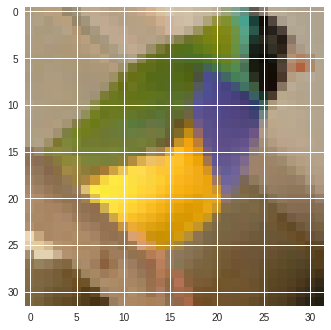

In [62]:
from matplotlib import pyplot as plt

print(x_train.shape, x_test.shape)
plt.imshow(x_train[11123]) #image in train set
print(y_train[11123])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


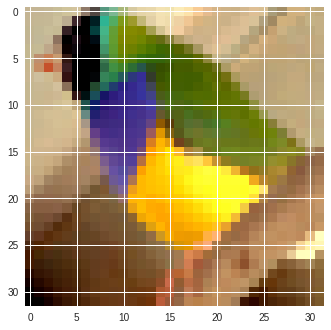

In [63]:
plt.imshow(x_aug[1]) #image in augumented set
print(y_aug[1])

In [12]:
print('shapes of x_train & y_train \n',x_train.shape,'\n',y_train.shape,'\n shapes of x_aug &y_aug \n',x_aug.shape,'\n',y_aug.shape)

shapes of x_train & y_train 
 (50000, 32, 32, 3) 
 (50000, 10) 
 shapes of x_aug &y_aug 
 (20000, 32, 32, 3) 
 (20000, 10)


### Appending augmented set of 20k images to main dataset

In [13]:
x_new = np.append(x_train, x_aug, axis=0) #new training set consisting of augment images & labels
y_new = np.append(y_train, y_aug, axis=0)
print('shapes of x_new & y_new \n',x_new.shape, y_new.shape)

shapes of x_new & y_new 
 (70000, 32, 32, 3) (70000, 10)


### ♦ Denseblock function

In [0]:
# Dense Block
def add_denseblock(input, l, num_filter = 24, dropout_rate):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_1_1 = Conv2D(int(num_filter*compression),(1,1), use_bias= False, padding='same')(relu)
        BatchNorm = BatchNormalization()(Conv2D_1_1)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

### ♦ Transition block, with composite layers of BatchNorm-Activation-BottleneckConv2D1x1-Dropout-2x2Pooling between two dense blocks

In [0]:
def add_transition(input, num_filter = 24, dropout_rate):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

### ♦ Final Dense layer following global pooling of 2x2

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

### Densenet architecture prior to training, with:
* 1 input layer
* Conv2D with 16, 3x3 kernel
* 4 denseBlock with layer depth l=6,12,16,12 alternatively with transition blocks
* 3 transition blocks

##### Sequence is as:
#### Input-Conv2D-Denseblock-Transition-Denseblock-Transition-Denseblock-Transition-Denseblock-Output 

In [0]:
#l = 12
input = Input(shape=(img_height, img_width, channel))
First_Conv2D = Conv2D(16, (3,3), use_bias=False ,padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros')(input)

First_Block = add_denseblock(First_Conv2D, 6 , num_filter, dropout_rate=0.2)
First_Transition = add_transition(First_Block, num_filter, dropout_rate=0.2)

Second_Block = add_denseblock(First_Transition,12, num_filter, dropout_rate=0.2)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate=0.2)

Third_Block = add_denseblock(Second_Transition,16, num_filter, dropout_rate=0.2)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate=0.2)

Last_Block = add_denseblock(Third_Transition,12, num_filter, dropout_rate=0.2)
output = output_layer(Last_Block)


### Model summary for above defined densenet architecture

In [0]:
model = Model(inputs=[input], outputs=[output])# model 2 with variable depth, l=6,12,16,12
model.summary() # model constant depth 1 with, l=12,12,12,12

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

activation_65 (Activation)      (None, 8, 8, 168)    0           batch_normalization_65[0][0]     
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 8, 8, 12)     2016        activation_65[0][0]              
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 8, 8, 12)     48          conv2d_66[0][0]                  
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 8, 8, 12)     0           batch_normalization_66[0][0]     
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 8, 8, 12)     1296        activation_66[0][0]              
__________________________________________________________________________________________________
dropout_34

#### Saving model architectures as json string

In [0]:
from keras.models import model_from_json
json_model1= model.to_json()#saving model_1 with variable value of l=6,12,16,12 through 4 dense blocks, dropout_rate= 0.2
print('model 1: \n',json_model1)

model 1: 
 {"class_name": "Model", "config": {"name": "model_1", "layers": [{"name": "input_1", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 32, 32, 3], "dtype": "float32", "sparse": false, "name": "input_1"}, "inbound_nodes": []}, {"name": "conv2d_1", "class_name": "Conv2D", "config": {"name": "conv2d_1", "trainable": true, "filters": 16, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"name": "batch_normalization_1", "class_name": "BatchNormalization", "config": {"name": "b

### Model Compilation: defining loss function, preferred optimizer fucntion

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

### Training and saving the model intermittently:
* using 70k training images as x_train & labels as y_train.
* with batch_size 128.
* and limited number of epochs each time.

In [0]:
#training model on 70k training images with Batch size = 128, epochs=5,dropout_rate= 0.2
model.fit(x_new, y_new, batch_size=batch_size, epochs=5, verbose=1, validation_data=(x_test, y_test))

from keras.models import load_model

model.save("./model127k_epoch1to5.h5") #saving model with architecture, weights and current state of optimizer

Train on 70000 samples, validate on 10000 samples
Epoch 1/5
44032/70000 [=================>............] - ETA: 2:46 - loss: 1.9464 - acc: 0.281370000/70000 [==============================] - 451s 6ms/step - loss: 1.8553 - acc: 0.3171 - val_loss: 1.7733 - val_acc: 0.3979
Epoch 2/5
18816/70000 [=======>......................] - ETA: 5:08 - loss: 1.6184 - acc: 0.406770000/70000 [==============================] - 430s 6ms/step - loss: 1.5439 - acc: 0.4380 - val_loss: 1.3793 - val_acc: 0.5110
Epoch 3/5
 9152/70000 [==>...........................] - ETA: 6:03 - loss: 1.4393 - acc: 0.479170000/70000 [==============================] - 428s 6ms/step - loss: 1.3920 - acc: 0.4971 - val_loss: 1.1563 - val_acc: 0.5885
Epoch 4/5
 5440/70000 [=>............................] - ETA: 6:28 - loss: 1.3020 - acc: 0.534670000/70000 [==============================] - 432s 6ms/step - loss: 1.2663 - acc: 0.5485 - val_loss: 1.4486 - val_acc: 0.5224
Epoch 5/5
 4032/70000 [>.............................] - ETA: 

#### reloading the previously saved model and first training for 5 epochs then 8 more epochs

In [0]:
#training model 2nd time on 70k training images with Batch size = 128, epochs=5, dropout_rate=0.20
from google.colab import files

model= load_model("model127k_epoch1to5.h5") #loading model with weights from training epoch 1 to 5 
model.fit(x_new, y_new,
                    batch_size=batch_size,
                    epochs=5,
                    verbose=1,
                    validation_data=(x_test, y_test))
model.save('./model127k_epoch1t10.h5')
files.download('model127k_epoch1t10.h5')

Train on 70000 samples, validate on 10000 samples
Epoch 1/5
44032/70000 [=================>............] - ETA: 2:46 - loss: 1.1170 - acc: 0.603570000/70000 [==============================] - 451s 6ms/step - loss: 1.1085 - acc: 0.6072 - val_loss: 0.9613 - val_acc: 0.6603
Epoch 2/5
18816/70000 [=======>......................] - ETA: 5:09 - loss: 1.0672 - acc: 0.621770000/70000 [==============================] - 431s 6ms/step - loss: 1.0549 - acc: 0.6285 - val_loss: 0.8957 - val_acc: 0.6998
Epoch 3/5
 9152/70000 [==>...........................] - ETA: 6:07 - loss: 1.0053 - acc: 0.642070000/70000 [==============================] - 435s 6ms/step - loss: 1.0121 - acc: 0.6414 - val_loss: 1.0942 - val_acc: 0.6543
Epoch 4/5
 5440/70000 [=>............................] - ETA: 6:25 - loss: 0.9871 - acc: 0.649370000/70000 [==============================] - 433s 6ms/step - loss: 0.9698 - acc: 0.6588 - val_loss: 0.9538 - val_acc: 0.6916
Epoch 5/5
 4032/70000 [>.............................] - ETA: 

In [0]:
#training model 3rd time on 70k training images with Batch size = 128, epochs=8, dropout_rate=0.20

model= load_model("model127k_epoch1t10.h5") #loading model with pretrained weights from epoch 1 to 10
model.fit(x_new, y_new,
                    batch_size=128,
                    epochs=8,
                    verbose=1,
                    validation_data=(x_test, y_test))
model.save('./model127k_epoch1t18.h5') #saving the complete model
files.download('model127k_epoch1t18.h5')

Train on 70000 samples, validate on 10000 samples
Epoch 1/8
70000/70000 [==============================] - 268s 4ms/step - loss: 0.8577 - acc: 0.6991 - val_loss: 0.9228 - val_acc: 0.6962
Epoch 2/8
 9216/70000 [==>...........................] - ETA: 3:36 - loss: 0.8325 - acc: 0.709470000/70000 [==============================] - 258s 4ms/step - loss: 0.8459 - acc: 0.7046 - val_loss: 0.7356 - val_acc: 0.7495
Epoch 3/8
34304/70000 [=============>................] - ETA: 2:07 - loss: 0.8264 - acc: 0.710670000/70000 [==============================] - 259s 4ms/step - loss: 0.8270 - acc: 0.7108 - val_loss: 0.7767 - val_acc: 0.7453
Epoch 4/8
43904/70000 [=================>............] - ETA: 1:32 - loss: 0.8151 - acc: 0.717370000/70000 [==============================] - 258s 4ms/step - loss: 0.8154 - acc: 0.7156 - val_loss: 0.7683 - val_acc: 0.7386
Epoch 5/8
47488/70000 [===================>..........] - ETA: 1:20 - loss: 0.7987 - acc: 0.720670000/70000 [==============================] - 258s 

In [14]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving model127k_ep1t18.h5 to model127k_ep1t18.h5
User uploaded file "model127k_ep1t18.h5" with length 2885848 bytes


### Saving only weights, discarding network architecture from recently trained model "model127k_ep1t18.h5, as the dropout value has to be changed from 0.2 to 0.3.

In [0]:
model= uploaded["model127k_ep1t18.h5"]

model= load_model("model127k_ep1t18.h5") #this loads the complete previous model "model127k_ep1t18.h5" with architecture, weights & state of optimizer 
model.save_weights("model127k_weights_ep1t18.h5")

In [25]:
!ls

datalab  model127k_ep1t18.h5  model127k_weights_ep1t18.h5


#### Differentiating model from previous one with dropout value =0.30
* So far the model has been trained for 18 epochs with dropout value=0.20.

In [0]:
num_filter = 24
dropout_rate = 0.3
#l = 12
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(16, (3,3), use_bias=False ,padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros')(input)

First_Block = add_denseblock(First_Conv2D, 6 , num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition,12, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition,16, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,12, num_filter, dropout_rate)
output = output_layer(Last_Block)

model = Model(inputs=[input], outputs=[output])# model 2 with variable depth, l=6,12,16,12 and dropout 0.30


In [0]:
model.load_weights("model127k_weights_ep1t18.h5") #adding pretrained weights "model127k_weights_ep1t18.h5" to new model with dropout 0.3

### Model Compilation: defining loss function, preferred optimizer fucntion

In [0]:
#compiling new model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

#### evaluating accuracy of the loaded model

In [37]:
score = model.evaluate(x_test, y_test, verbose=1) #val. accuracy arising from "model127k_weights_ep1t18.h5" pretrained weights
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 23s 2ms/step
Test loss: 0.6169136631727219
Test accuracy: 0.7916


### Model summary of above defined densenet architecture

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Saving model architectures as json string

In [31]:
from keras.models import model_from_json
json_model2= model.to_json()##saving model_2 with variable value of l=6,12,16,12 through 4 dense blocks with dropout of 0.3
print('model 2: \n',json_model2)

model 2: 
 {"class_name": "Model", "config": {"name": "model_1", "layers": [{"name": "input_1", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 32, 32, 3], "dtype": "float32", "sparse": false, "name": "input_1"}, "inbound_nodes": []}, {"name": "conv2d_1", "class_name": "Conv2D", "config": {"name": "conv2d_1", "trainable": true, "filters": 16, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"name": "batch_normalization_1", "class_name": "BatchNormalization", "config": {"name": "b

### Adding 35k more augmented images to existing training dataset.

In [33]:
##adding 35kk augumented images to original training data

augidx = np.random.randint(0,50000, size=(35000))
print(augidx.shape)
x_aug = aug_seq.augment_images(x_train[augidx])
y_aug= y_train[augidx]


print('shapes of x_train & y_train \n',x_train.shape,'\n',y_train.shape,'\n shapes of x_aug &y_aug \n',x_aug.shape,'\n',y_aug.shape)
x_new = np.append(x_train, x_aug, axis=0) #new training set consisting of augment images & labels
y_new = np.append(y_train, y_aug, axis=0)
print('shapes of x_new & y_new \n',x_new.shape, y_new.shape)

(35000,)
shapes of x_train & y_train 
 (50000, 32, 32, 3) 
 (50000, 10) 
 shapes of x_aug &y_aug 
 (35000, 32, 32, 3) 
 (35000, 10)
shapes of x_new & y_new 
 (85000, 32, 32, 3) (85000, 10)


### Model training:
* using 85k training images
* batch_size 128
* 8 epochs
#### The model would then be trained well over 24 epochs in total.

In [40]:
model.fit(x_new, y_new, batch_size=128, epochs=8, verbose=1,validation_data=(x_test, y_test))
#training model 4th time on 85k training images, Batch size = 128, epochs=8 with dropout 0.30

Train on 85000 samples, validate on 10000 samples
Epoch 1/8
85000/85000 [==============================] - 329s 4ms/step - loss: 0.9567 - acc: 0.6685 - val_loss: 0.7488 - val_acc: 0.7474
Epoch 2/8
 1408/85000 [..............................] - ETA: 4:56 - loss: 0.9866 - acc: 0.644985000/85000 [==============================] - 307s 4ms/step - loss: 0.9377 - acc: 0.6723 - val_loss: 1.2245 - val_acc: 0.6574
Epoch 3/8
25472/85000 [=======>......................] - ETA: 3:27 - loss: 0.9311 - acc: 0.674585000/85000 [==============================] - 306s 4ms/step - loss: 0.9234 - acc: 0.6778 - val_loss: 0.8478 - val_acc: 0.7332
Epoch 4/8
34688/85000 [===========>..................] - ETA: 2:57 - loss: 0.9123 - acc: 0.681885000/85000 [==============================] - 308s 4ms/step - loss: 0.9135 - acc: 0.6806 - val_loss: 0.8612 - val_acc: 0.7333
Epoch 5/8
38272/85000 [============>.................] - ETA: 2:44 - loss: 0.9078 - acc: 0.682185000/85000 [==============================] - 307s 

#### Saving & downloading the final model

In [0]:
model.save('./modeldrop_0.3_127k_ep1t26.h5') #saving the model with dropout 0.30, training for total 26 epochs
files.download('modeldrop_0.3_127k_ep1t26.h5')

In [42]:
!ls

datalab		     model127k_weights_ep1t18.h5
model127k_ep1t18.h5  modeldrop_0.3_127k_ep1t26.h5


### evaluating validation scores

In [50]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 26s 3ms/step
Test loss: 0.5841944081783295
Test accuracy: 0.8068


#### Saving & downloading the final model weights

In [0]:
# Save the trained weights in to .h5 format
model.save_weights("final_weights.h5")
files.download("final_weights.h5")